# Исследовательский анализ данных Яндекс Афиша

## Цель проекта : разобраться, какие события стали привлекать больше зрителей, а какие организаторы и площадки выбились в лидеры. А также понять, отличаются ли своей активностью пользователи мобильных устройств от клиентов, которые бронируют билеты со стационарного компьютера.

Автор: Дорошенко Евгений

Дата: 09.09.2025

## Описание данных:

Первый датасет final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов  устройств — мобильных и стационарных. Поля датасета соответствуют таблице purchases, с которой вы работали в предыдущих заданиях:
- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, - desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.

В данные также был добавлен столбец days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет final_tickets_events_df содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Обратите внимание, что из данных исключили фильмы, ведь, как было видно на дашборде, событий такого типа не так много. Датасет содержит такие поля:
- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.

Анализ данных в предыдущей части проекта показал, что выручка от заказов представлена в двух валютах — российских рублях и казахстанских тенге. Для удобства решения было бы корректно привести данные к одной валюте, например к российским рублям. Для этого в вашем распоряжении будет датасет final_tickets_tenge_df.csv с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
nominal — номинал (100 тенге).
- data — дата.
- curs — курс тенге к рублю.
- cdx — обозначение валюты (kzt).

Используйте эти данные для конвертации валюты.

### Содержание проекта


- 1)Оглавление и цель проекта
- 2)Загрузка данных и знакомство с ними
- 3)Исследовательский анализ данных    
  - Анализ распределения заказов по сегментам и их сезонные изменения
  - Осенняя активность пользователей
  - Популярные события и партнёры
- 4)Статистический анализ данных
- 5)Осенняя активность пользователей
- 6)Общий вывод и рекомендации

    

# Загрузка данных и знакомство с ними

In [1]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import scipy.stats as stats
from scipy.stats import mannwhitneyu, ttest_ind







In [2]:
# Открытие данных
df_orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
df_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
df_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')


In [3]:
# Рабочий код
display(df_orders.head())
display(df_events.head())
display(df_tenge.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [4]:
# Общая информация о данных
display(df_orders.info())
display(df_events.info())
display(df_tenge.info())



<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 290849 entries, 0 to 290848
,Data columns (total 14 columns):
, #   Column                 Non-Null Count   Dtype  
,---  ------                 --------------   -----  
, 0   order_id               290849 non-null  int64  
, 1   user_id                290849 non-null  object 
, 2   created_dt_msk         290849 non-null  object 
, 3   created_ts_msk         290849 non-null  object 
, 4   event_id               290849 non-null  int64  
, 5   cinema_circuit         290849 non-null  object 
, 6   age_limit              290849 non-null  int64  
, 7   currency_code          290849 non-null  object 
, 8   device_type_canonical  290849 non-null  object 
, 9   revenue                290849 non-null  float64
, 10  service_name           290849 non-null  object 
, 11  tickets_count          290849 non-null  int64  
, 12  total                  290849 non-null  float64
, 13  days_since_prev        268909 non-null  float64
,dtypes: float64(3), in

None

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 22427 entries, 0 to 22426
,Data columns (total 11 columns):
, #   Column                  Non-Null Count  Dtype 
,---  ------                  --------------  ----- 
, 0   event_id                22427 non-null  int64 
, 1   event_name              22427 non-null  object
, 2   event_type_description  22427 non-null  object
, 3   event_type_main         22427 non-null  object
, 4   organizers              22427 non-null  object
, 5   region_name             22427 non-null  object
, 6   city_name               22427 non-null  object
, 7   city_id                 22427 non-null  int64 
, 8   venue_id                22427 non-null  int64 
, 9   venue_name              22427 non-null  object
, 10  venue_address           22427 non-null  object
,dtypes: int64(3), object(8)
,memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 357 entries, 0 to 356
,Data columns (total 4 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   data     357 non-null    object 
, 1   nominal  357 non-null    int64  
, 2   curs     357 non-null    float64
, 3   cdx      357 non-null    object 
,dtypes: float64(1), int64(1), object(2)
,memory usage: 11.3+ KB


None

Данные:
df_orders: содержит информацию о заказах, включая идентификатор заказа, пользователя, дату и время создания заказа, идентификатор события, возрастные ограничения и другие атрибуты.
df_events: содержит данные о событиях, включая идентификатор события, название, описание типа события, организаторов и местоположение.
df_tenge: таблица с курсами валюты.

Качество данных:
В df_orders есть пропуски в столбце days_since_prev (268909 non-null из 290849).
Все остальные столбцы в каждой из таблиц полностью заполнены (нет пропусков).

Типы данных:
Основные типы данных в таблицах — int64, float64 и object.
Потребуется преобразование типов данных для некоторых столбцов, например, преобразование дат в формат datetime.

In [5]:
# Для удобства обеденим таблицы в один датасет.
# Но сначала провериим кол-во строк до и после слияния

print("Размер df_orders:", df_orders.shape)
print("Размер df_events:", df_events.shape)
print("Размер df_tenge:", df_tenge.shape)


Размер df_orders: (290849, 14)
,Размер df_events: (22427, 11)
,Размер df_tenge: (357, 4)


In [6]:
# Объеденим таблицы в один датасет
merged_df = pd.merge(df_orders, df_events, on='event_id')
merged_df = pd.merge(merged_df, df_tenge, left_on='created_dt_msk', right_on='data')
print("Размер merged_df после объединения:", merged_df.shape)


Размер merged_df после объединения: (290611, 28)


 - После объединения размер результирующего датафрейма merged_df немного уменьшился по сравнению с исходным df_orders. Это может быть связано с тем, что не для всех строк нашлось соответствие по ключу при объединении.

In [7]:
# Проверим на пропуски
merged_df.isna().sum()


order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
data                          0
nominal                       0
curs                          0
cdx                           0
dtype: int64

In [8]:
# Проверим долип пропусков от общего числа
merged_df.isna().mean()

order_id                  0.000000
user_id                   0.000000
created_dt_msk            0.000000
created_ts_msk            0.000000
event_id                  0.000000
cinema_circuit            0.000000
age_limit                 0.000000
currency_code             0.000000
device_type_canonical     0.000000
revenue                   0.000000
service_name              0.000000
tickets_count             0.000000
total                     0.000000
days_since_prev           0.075403
event_name                0.000000
event_type_description    0.000000
event_type_main           0.000000
organizers                0.000000
region_name               0.000000
city_name                 0.000000
city_id                   0.000000
venue_id                  0.000000
venue_name                0.000000
venue_address             0.000000
data                      0.000000
nominal                   0.000000
curs                      0.000000
cdx                       0.000000
dtype: float64

Обнаружено пропускрв - 21913 или 7,5%  строк в одном столбце days_since_prev что объяснялось в ТЗ          

In [9]:
# Проверка дубликатов в объединённом датафрейме
print('Дубликаты в merged_df:', merged_df.duplicated().sum())

Дубликаты в merged_df: 0


In [10]:
# Приведем столбец с датой к datetime
merged_df['created_ts_msk'] = pd.to_datetime(merged_df['created_ts_msk'], errors='coerce')  # дата + время

In [11]:
# Для удобства округлим временную метку до минут (исключить эффект микросекунд)
merged_df['created_ts_rounded'] = pd.to_datetime(merged_df['created_ts_msk']).dt.floor('T')

# Столбцы, идентифицирующие бронь (без order_id):
key_cols = ['user_id', 'created_ts_rounded', 'event_id', 'tickets_count', 'total', 'device_type_canonical']

# Проверка дубликатов по этим полям
duplicate_mask = merged_df.duplicated(subset=key_cols, keep=False)

# Посмотрим, сколько таких неявных дубликатов
num_implicit_duplicates = duplicate_mask.sum()
print(f'Количество неявных дубликатов бронирования: {num_implicit_duplicates}')

# Посмотрим примеры (если есть)
if num_implicit_duplicates > 0:
    print(merged_df.loc[duplicate_mask].sort_values(by=key_cols).head(10))
else:
    print("Неявных дубликатов бронирования не найдено.")

Количество неявных дубликатов бронирования: 6064
,        order_id          user_id created_dt_msk      created_ts_msk  \
,201360    865361  00fcd3ab0e5c558     2024-10-01 2024-10-01 11:38:40   
,201361    865506  00fcd3ab0e5c558     2024-10-01 2024-10-01 11:38:10   
,218629   5679100  0186f6e000b581c     2024-10-10 2024-10-10 14:30:38   
,218637   5679013  0186f6e000b581c     2024-10-10 2024-10-10 14:30:24   
,149034   6893852  019fa401ddb00aa     2024-07-28 2024-07-28 11:26:05   
,149040    524379  019fa401ddb00aa     2024-07-28 2024-07-28 11:26:01   
,11368    2459317  019fa401ddb00aa     2024-09-11 2024-09-11 22:37:32   
,11371    2459375  019fa401ddb00aa     2024-09-11 2024-09-11 22:37:55   
,42128     331268  019fa401ddb00aa     2024-09-14 2024-09-14 16:47:09   
,42130     331326  019fa401ddb00aa     2024-09-14 2024-09-14 16:47:47   
,
,        event_id cinema_circuit  age_limit currency_code  \
,201360    457197            нет          0           rub   
,201361    457197       

Обнаружены неявные дубликаты бронирований (разные order_id, остальное совпадает). Нельзя однозначно исключить, что это:

- Один и тот же ползователь покупал много билетов за день возможно корпаративные мероприятия с одним заказзчиком.
 - Повторные попытки пользователя (сбои, неуверенность).
 - Разные сессии (с разных устройств).

Удаление может привести к потере реальных броней.По этому оставлялем неявные дубликаты как есть.



In [12]:
# 3.3: Конвертация валюты
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        # Проверяем, есть ли данные о курсе
        if pd.isna(row['curs']):
            return None  # Если нет данных о курсе, возвращаем None

        return row['revenue'] * (row['curs'] / 100)
    else:
        return None

merged_df['revenue_rub'] = merged_df.apply(convert_to_rub, axis=1)
print(merged_df[['revenue', 'currency_code', 'created_dt_msk', 'curs', 'revenue_rub']].head())


   revenue currency_code created_dt_msk     curs  revenue_rub
,0  1521.94           rub     2024-08-20  18.6972      1521.94
,1   144.73           rub     2024-08-20  18.6972       144.73
,2   318.27           rub     2024-08-20  18.6972       318.27
,3   339.61           rub     2024-08-20  18.6972       339.61
,4   339.61           rub     2024-08-20  18.6972       339.61


In [13]:
# 3.4: Создание новых столбцов
merged_df['one_ticket_revenue_rub'] = merged_df['revenue_rub'] / merged_df['tickets_count']
merged_df['month'] = merged_df['created_ts_msk'].dt.month

def get_season(month):
    if 3 <= month <= 5:
        return 'весна'
    elif 6 <= month <= 8:
        return 'лето'
    elif 9 <= month <= 11:
        return 'осень'
    else:
        return 'зима'

merged_df['season'] = merged_df['month'].apply(get_season)


In [14]:
display("\nПервые строки обработанного датафрейма:\n", merged_df.head())

'\nПервые строки обработанного датафрейма:\n'

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_address,data,nominal,curs,cdx,created_ts_rounded,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,2024-08-20 16:08:00,1521.94,380.485,8,лето
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.73,...,"алл. Шмидта, д. 9 стр. 4",2024-08-20,100,18.6972,kzt,2024-08-20 22:12:00,144.73,144.730,8,лето
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.27,...,"наб. Тамбовская, д. 1/4 к. 577",2024-08-20,100,18.6972,kzt,2024-08-20 15:29:00,318.27,106.090,8,лето
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.61,...,"ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt,2024-08-20 17:06:00,339.61,339.610,8,лето
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.61,...,"ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt,2024-08-20 02:57:00,339.61,339.610,8,лето


In [15]:
# 3.6: Анализ категориальных переменных
print("\nУникальные значения в категориальных столбцах:")
for col in merged_df.select_dtypes(include='object'):
    print(f"\nСтолбец '{col}':")
    print(merged_df[col].unique())
    print(f"Количество уникальных значений: {merged_df[col].nunique()}")


,Уникальные значения в категориальных столбцах:
,
,Столбец 'user_id':
,['0002849b70a3ce2' '44c1c640a242aea' '2b1f730d7024681' ...
, '799e02306e55c7b' 'd57aff1cb684be3' 'dba05ea9c08d8b2']
,Количество уникальных значений: 21933
,
,Столбец 'created_dt_msk':
,['2024-08-20' '2024-07-23' '2024-07-21' '2024-08-17' '2024-07-25'
, '2024-08-29' '2024-10-21' '2024-09-11' '2024-07-22' '2024-10-11'
, '2024-10-23' '2024-10-22' '2024-10-24' '2024-08-24' '2024-07-02'
, '2024-07-09' '2024-09-23' '2024-07-16' '2024-10-30' '2024-08-23'
, '2024-07-10' '2024-07-29' '2024-09-14' '2024-09-09' '2024-10-26'
, '2024-10-27' '2024-06-28' '2024-07-17' '2024-10-17' '2024-08-01'
, '2024-07-08' '2024-08-04' '2024-08-06' '2024-07-31' '2024-10-31'
, '2024-08-26' '2024-10-19' '2024-07-26' '2024-10-20' '2024-08-25'
, '2024-06-09' '2024-08-12' '2024-10-18' '2024-08-22' '2024-10-08'
, '2024-07-20' '2024-07-12' '2024-07-13' '2024-08-16' '2024-07-15'
, '2024-07-19' '2024-07-30' '2024-08-10' '2024-08-09' '2024-10-29'
, '2024

 - Анализ категориальных переменных показал:


user_id: Много уникальных значений (21933), каждый ID - отдельный пользователь.

created_dt_msk: 153 уникальные даты в диапазоне с 2024-06-01 по 2024-10-31. Привести к типу datetime.

cinema_circuit: 6 киносетей.

currency_code: 2 используемые валюты (rub, kzt).

device_type_canonical: 2 типа устройств (mobile, desktop).

service_name: 36 сервисов продажи билетов.

event_name: Очень много уникальных названий событий (15248) 

event_type_description: 20 типов событий.

event_type_main: 7 основных категорий событий.

organizers: 4293 организатора.

region_name: 81 регион. Объединить малочисленные в "Другие".

city_name: 359 городов. Объединить малочисленные в "Другие".

In [16]:
# 3.7: Анализ количественных переменных и выбросов
print("\nСтатистические показатели количественных переменных:")
print(merged_df[['revenue', 'tickets_count', 'revenue_rub', 'one_ticket_revenue_rub']].describe())



,Статистические показатели количественных переменных:
,             revenue  tickets_count    revenue_rub  one_ticket_revenue_rub
,count  290611.000000  290611.000000  290611.000000           290611.000000
,mean      625.584360       2.754311     555.571987              201.189419
,std      1227.693064       1.170620     875.498172              302.852946
,min       -90.760000       1.000000     -90.760000              -18.152000
,25%       116.850000       2.000000     113.970000               46.820000
,50%       356.010000       3.000000     351.140000              149.710000
,75%       810.130000       4.000000     802.050000              308.700000
,max     81174.540000      57.000000   81174.540000            21757.540000


In [17]:
# Предположим, что ваш DataFrame называется merged_df, а столбец с выручкой - 'revenue_rub'
Q1 = merged_df['revenue_rub'].quantile(0.25)
Q3 = merged_df['revenue_rub'].quantile(0.75)
IQR = Q3 - Q1

# Определим верхнюю границу выбросов (можно настроить коэффициент)
upper_bound = Q3 +  3* IQR  #3 - коэф

# Фильтруем DataFrame, чтобы найти выбросы
outliers = merged_df[merged_df['revenue_rub'] > upper_bound]

# Рассчитываем долю выбросов от общего количества данных
outlier_percentage = (len(outliers) / len(merged_df)) * 100

print(f"Доля выбросов: {outlier_percentage:.2f}%")

Доля выбросов: 0.65%


 - Анализ количественных переменных:


revenue/revenue_rub: Средняя выручка 555-625, большой разброс, может быть связано с днями когда были какие то крупные фестивали или концерты.

tickets_count: В среднем ~2.7 билета, макс. 57 (выброс).

one_ticket_revenue_rub: Средняя цена билета ~201, большой разброс, макс. 21757 (выброс).

Есть отрицательные значения воможно это связано с возвратом ДС клиенту.

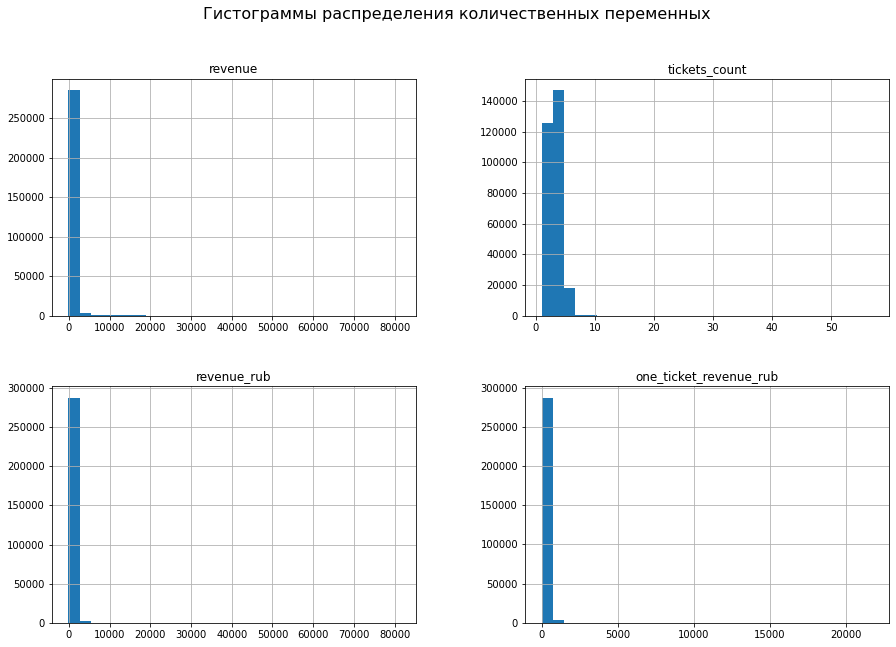

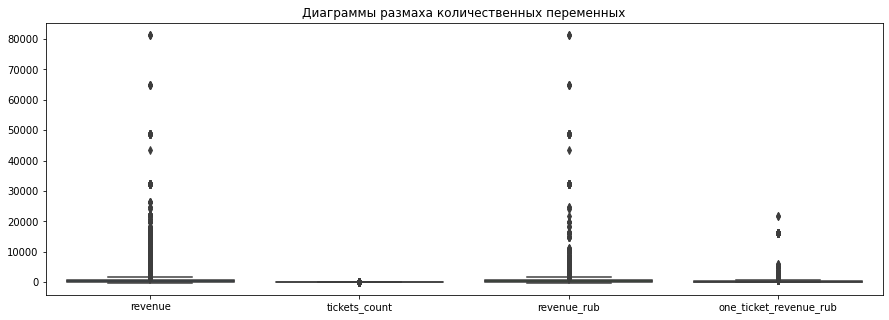


,Выбросы в выручке (revenue):
,
,Рублевая выручка:
,count    285542.000000
,mean        548.013929
,std         871.750181
,min         -90.760000
,25%         114.170000
,50%         346.630000
,75%         793.320000
,max       81174.540000
,Name: revenue, dtype: float64
,
,Тенговая выручка:
,count     5069.000000
,mean      4995.206767
,std       4916.752776
,min          0.000000
,25%        518.100000
,50%       3698.830000
,75%       7397.660000
,max      26425.860000
,Name: revenue, dtype: float64


In [18]:
# Гистограммы распределения
merged_df[['revenue', 'tickets_count', 'revenue_rub', 'one_ticket_revenue_rub']].hist(bins=30, figsize=(15, 10))
plt.suptitle('Гистограммы распределения количественных переменных', fontsize=16)
plt.show()


# Диаграммы размаха
plt.figure(figsize=(15, 5))
sns.boxplot(data=merged_df[['revenue', 'tickets_count', 'revenue_rub', 'one_ticket_revenue_rub']])
plt.title('Диаграммы размаха количественных переменных')
plt.show()

# Анализ выбросов в выручке (revenue)
print("\nВыбросы в выручке (revenue):")
# Разделим на рубли и тенге для анализа
rub_revenue = merged_df[merged_df['currency_code'] == 'rub']['revenue']
kzt_revenue = merged_df[merged_df['currency_code'] == 'kzt']['revenue']

print("\nРублевая выручка:")
print(rub_revenue.describe())
print("\nТенговая выручка:")
print(kzt_revenue.describe())

In [19]:
# 99-й процентиль для рублевой выручки
rub_99_percentile = rub_revenue.quantile(0.99)
print(f"\nРублевая выручка (99-й процентиль): {rub_99_percentile}")

# 99-й процентиль для тенговой выручки
kzt_99_percentile = kzt_revenue.quantile(0.99)
print(f"Тенговая выручка (99-й процентиль): {kzt_99_percentile}")

# Отфильтруем выбросы по 99-му процентилю 
merged_df_filtered = merged_df[((merged_df['currency_code'] == 'rub') & (merged_df['revenue'] <= rub_99_percentile)) |
                               ((merged_df['currency_code'] == 'kzt') & (merged_df['revenue'] <= kzt_99_percentile)) |
                               (merged_df['currency_code'] != 'rub' ) & (merged_df['currency_code'] != 'kzt')]  # Оставляем заказы в других валютах, если есть

print("\nРазмер DataFrame после фильтрации выбросов:", merged_df_filtered.shape)


,Рублевая выручка (99-й процентиль): 2570.8
,Тенговая выручка (99-й процентиль): 17617.24
,
,Размер DataFrame после фильтрации выбросов: (287782, 33)


In [20]:
# Посчитаем долю срезанных данных
Q1 = merged_df['revenue_rub'].quantile(0.25)
Q3 = merged_df['revenue_rub'].quantile(0.75)
IQR = Q3 - Q1

# Определим верхнюю границу выбросов (можно настроить коэффициент)
upper_bound = Q3 +  3* IQR  #3 - коэф

# Фильтруем DataFrame, чтобы найти выбросы
outliers = merged_df[merged_df['revenue_rub'] > upper_bound]

# Рассчитываем долю выбросов от общего количества данных
outlier_percentage = (len(outliers) / len(merged_df)) * 100

print(f"Доля выбросов: {outlier_percentage:.2f}%")

Доля выбросов: 0.65%


### Промежуточный вывод:

Данные загружены и объединены:

Исходные таблицы: df_orders, df_events, df_tenge.
Итоговый датафрейм merged_df содержит все ключевые данные для анализа.
Количество строк и колонок в объединённом датафрейме:

Около 290 тысяч строк.
28 столбцов (объединены признаки заказов, мероприятий и курса тенге).
Качество данных:

Отсутствуют дубликаты в merged_df.

Так же обнаружено 6064 неявных дубликатов. На примере нескольких строк показано, что пары записей отличаются только по order_id и created_ts_msk, но совпадают по другим полям: user_id, event_id, city_name, venue_name, revenue и другим.Скорее всего это может быть свзяно что один и тоже пользователь может делать заказы неоднократно за день.

Пропуски есть только в поле days_since_prev (около 22 тысяч строк), что логично для первых заказов пользователей.По этому пропуски оставим без изменений.

В итоге пропуски и дубли решено было оставить как.

Также провели преобразование даты в datetime 

Анализ выручки в рублях (rub):
Количество наблюдений достаточно большое — 285542 значений.
Средняя выручка — около 548 рублей.
Медиана (50% квантиль) — 346.63 рубля, что существенно ниже среднего, указывает на ассиметрию распределения вправо (наличие больших значений, которые тянут среднее вверх).
25% и 75% квантиль: 114.17 и 793.32 — значит, половина данных сосредоточена в широком диапазоне.
Минимальное значение отрицательное (-90.76 рубля) — вероятно, это ошибка или возврат/коррекция, требует проверки.
Максимальное значение очень большое (81174.54 рубля), что говорит о наличии выбросов.
выручка в рублях (revenue_rub) совпадает с изначальной для рублёвых заказов;
Также -посчитана выручка за один билет (one_ticket_revenue_rub);
определён месяц и сезон.

Были созданы дополнительные столбцы

revenue_rub - выручка в руб.
one_ticket_revenue_rub - выручка с одного билета
month - месяц (номер)
season - сезон


Расчет доли "срезанных" данных (выбросов): Анализ выбросов проводился на основе столбца revenue_rub, поскольку большая часть транзакций совершается в рублях. Выбросы определялись как значения, превышающие Q3 + 3 * IQR. Доля выбросов, определенных на основе revenue_rub, составляет 0.69% от общего объема данных.  На данном этапе данные по выбросам мы их не удаляем.]

# Исследовательский анализ данных

###  Анализ распределения заказов по сегментам и их сезонные изменения

- Помесячная динамика заказов (проверка роста с июня к ноябрю 2024)

In [21]:
sns.set(style='whitegrid')
plt.rcParams.update({'figure.figsize': (11,5)})

# order_id в данных — используем его, иначе replace на индекс или другую колонку уникального заказа
order_col = 'order_id' if 'order_id' in merged_df.columns else None

# фильтр по 2024 (при необходимости поменяйте год)
df24 = merged_df[merged_df['created_ts_msk'].dt.year == 2024].copy()

In [22]:
# помесячные количества заказов
if order_col:
    monthly = df24.groupby(df24['created_ts_msk'].dt.to_period('M')).agg(orders=(order_col,'nunique')).reset_index()
else:
    monthly = df24.groupby(df24['created_ts_msk'].dt.to_period('M')).agg(orders=('created_ts_msk','count')).reset_index()

monthly['month_dt'] = monthly['created_ts_msk'].dt.to_timestamp()
monthly = monthly.sort_values('month_dt')

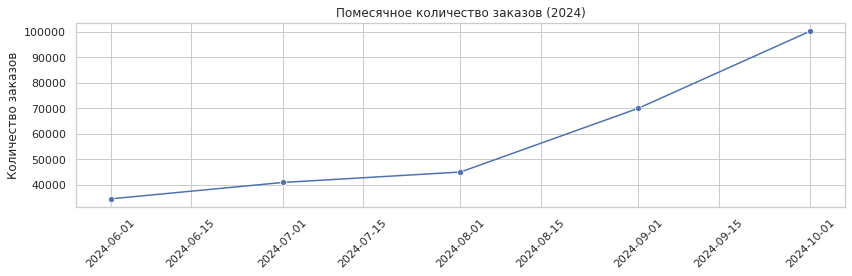

In [23]:
# график
plt.figure(figsize=(12,4))
sns.lineplot(data=monthly, x='month_dt', y='orders', marker='o')
plt.title('Помесячное количество заказов (2024)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.show()

In [24]:
# month_dt — datetime
monthly['period'] = monthly['month_dt'].dt.to_period('M')

jun = monthly.loc[monthly['period'] == pd.Period('2024-06'), 'orders'].sum()
oct_ = monthly.loc[monthly['period'] == pd.Period('2024-10'), 'orders'].sum()  # октябрь = 10
nov = monthly.loc[monthly['period'] == pd.Period('2024-11'), 'orders'].sum()   # ноябрь = 11

print(f"Июнь 2024: {jun} заказов; Октябрь 2024: {oct_} заказов; Ноябрь 2024: {nov} заказов")

def rel_change(old, new):
    if old == 0 and new == 0:
        return 0.0
    if old == 0:
        return float('inf')  # или None / np.nan — по смыслу
    return (new - old) / old

# пример: октябрь vs июнь
if jun == 0:
    print("Июнь = 0, относительное изменение вычислить невозможно.")
else:
    print(f"Относительное изменение (Oct vs Jun): {rel_change(jun, oct_):.2%}")


Июнь 2024: 34504 заказов; Октябрь 2024: 100210 заказов; Ноябрь 2024: 0 заказов
,Относительное изменение (Oct vs Jun): 190.43%


In [25]:
def season_shares(df, col, season_col='season', top_n=12, order_col=None):
    sel = df[df[season_col].isin(['лето', 'осень'])].copy()

    # считаем заказы (или строки)
    if order_col and order_col in sel.columns:
        grp = sel.groupby([season_col, col])[order_col].nunique().reset_index(name='orders')
    else:
        grp = sel.groupby([season_col, col]).size().reset_index(name='orders')

    # доли внутри сезона
    grp['season_total'] = grp.groupby(season_col)['orders'].transform('sum')
    grp['share'] = grp['orders'] / grp['season_total']

    # топ-N категорий по суммарным заказам (лето+осень); остальные — 'Другие'
    top = grp.groupby(col)['orders'].sum().nlargest(top_n).index.tolist()
    grp[col] = grp[col].where(grp[col].isin(top), 'Другие')

    # агрегируем уже с объединёнными категориями
    pivot_share = grp.groupby([col, season_col])[['orders', 'share']].sum().reset_index()

    # делаем pivot по долям (лето/осень)
    pivot = pivot_share.pivot(index=col, columns=season_col, values='share').fillna(0).reset_index()

    return pivot.sort_values(by=list([c for c in ['лето','осень'] if c in pivot.columns]), ascending=False)


In [26]:
# Применение:
pivot_event = season_shares(df24, 'event_type_main', top_n=12)
pivot_device = season_shares(df24, 'device_type_canonical', top_n=6)


In [27]:
# Визуализация 
def plot_season_share(pivot, cat_col, title):
    data = pivot.melt(id_vars=[cat_col], value_vars=['лето','осень'], var_name='season', value_name='share')
    plt.figure(figsize=(10, max(4, len(pivot)*0.4)))
    sns.barplot(data=data, x='share', y=cat_col, hue='season')
    plt.xlabel('Доля заказов в сезоне')
    plt.title(title)
    plt.xlim(0, data['share'].max()*1.1)
    plt.legend(title='')
    plt.tight_layout()
    plt.show()

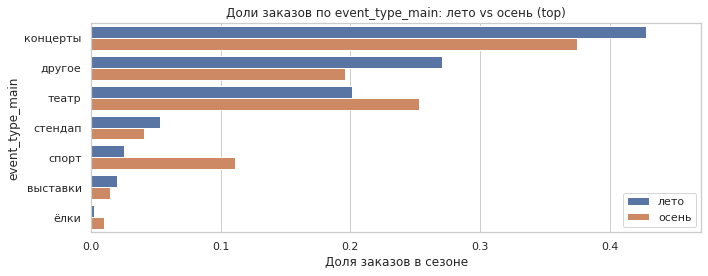

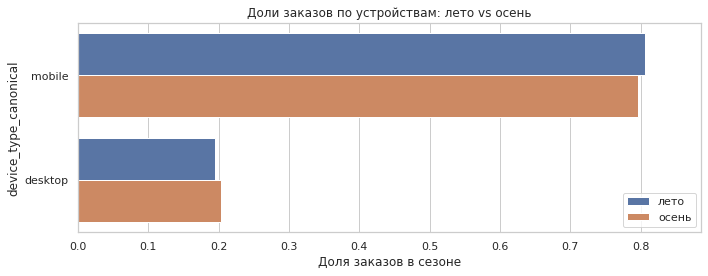

In [28]:
plot_season_share(pivot_event, 'event_type_main', 'Доли заказов по event_type_main: лето vs осень (top)')
plot_season_share(pivot_device, 'device_type_canonical', 'Доли заказов по устройствам: лето vs осень')

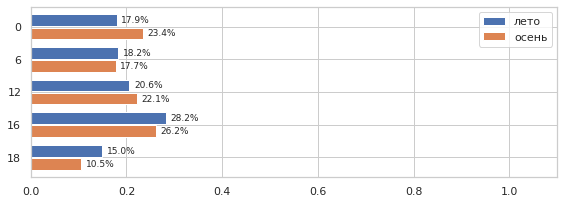

season age_limit      лето     осень
,0              0  0.179473  0.234300
,1              6  0.182387  0.177435
,2             12  0.205977  0.221343
,3             16  0.282407  0.261754
,4             18  0.149756  0.105168


In [29]:
# Доля заказов по возврасту в разрезе сезона
def season_shares_plot(df, col, season_col='season', top_n=8, order_col=None, seasons=('лето','осень')):
    df = df.copy()
    df[season_col] = df[season_col].astype(str).str.strip()
    df = df[df[season_col].isin(seasons)]
    if order_col and order_col in df.columns:
        g = df.groupby([season_col, col])[order_col].nunique().reset_index(name='orders')
    else:
        g = df.groupby([season_col, col]).size().reset_index(name='orders')
    top = g.groupby(col)['orders'].sum().nlargest(top_n).index
    g[col] = g[col].where(g[col].isin(top), 'Другие')
    g = g.groupby([season_col, col])['orders'].sum().reset_index()
    g['share'] = g['orders'] / g.groupby(season_col)['orders'].transform('sum')
    p = g.pivot(index=col, columns=season_col, values='share').fillna(0).reset_index()
    p[col] = p[col].astype(str)
    # plot
    seasons_present = [s for s in seasons if s in p.columns]
    cats = p[col].tolist(); n=len(cats); ind=np.arange(n)
    w_total=0.8; w=w_total/max(1,len(seasons_present))
    plt.figure(figsize=(8, max(3, n*0.35)))
    for i,s in enumerate(seasons_present):
        vals=p[s].values; pos=ind - w_total/2 + i*w + w/2
        plt.barh(pos, vals, height=w*0.9, label=s)
        for x,y in zip(vals,pos): plt.text(x+0.01,y,f"{x:.1%}",va='center',fontsize=9)
    plt.yticks(ind,cats); plt.gca().invert_yaxis(); plt.xlim(0, max(1.0, p[seasons_present].values.max())*1.1)
    plt.legend(); plt.tight_layout(); plt.show()
    return p

pivot_age = season_shares_plot(df24, 'age_limit', top_n=8)
print(pivot_age)              # печать таблицы


In [30]:
# считаем среднюю выручку по event_type_main и сезону
rev = df24[df24['season'].isin(['лето','осень'])].groupby(['event_type_main','season']).agg(
    mean_ticket=('one_ticket_revenue_rub','mean'),
    median_ticket=('one_ticket_revenue_rub','median'),
    n=('one_ticket_revenue_rub','count')
).reset_index()

# pivot для расчёта относительного изменения
rev_pivot = rev.pivot(index='event_type_main', columns='season', values=['mean_ticket','n'])
# упрощаем имена колонок
rev_pivot.columns = ['_'.join(col).strip() for col in rev_pivot.columns.values]
rev_pivot = rev_pivot.reset_index().fillna(0)

# относительное изменение: (осень - лето) / лето
rev_pivot['rel_change'] = np.where(rev_pivot['mean_ticket_лето'] > 0,
                                   (rev_pivot['mean_ticket_осень'] - rev_pivot['mean_ticket_лето']) / rev_pivot['mean_ticket_лето'],
                                   np.nan)

# Относительное изменение в процентах
rev_pivot['rel_change_percent'] = rev_pivot['rel_change'] * 100

# таблица с сортировкой по объёму наблюдений или по абсолютному изменению
display_cols = ['event_type_main','mean_ticket_лето','mean_ticket_осень','rel_change','n_лето','n_осень']
display_df = rev_pivot[display_cols].sort_values('n_осень', ascending=False)
display_df.head(30)


,event_type_main,mean_ticket_лето,mean_ticket_осень,rel_change,n_лето,n_осень
2,концерты,319.079883,286.757220,-0.101300,51539.0,63737.0
5,театр,222.528475,183.047178,-0.177421,24215.0,43106.0
1,другое,81.091084,77.107792,-0.049121,32575.0,33292.0
3,спорт,54.112065,52.132324,-0.036586,3013.0,18898.0
4,стендап,227.070677,249.963862,0.100820,6401.0,6992.0
0,выставки,86.388607,91.066619,0.054151,2417.0,2437.0
6,ёлки,276.388228,234.503838,-0.151542,276.0,1713.0


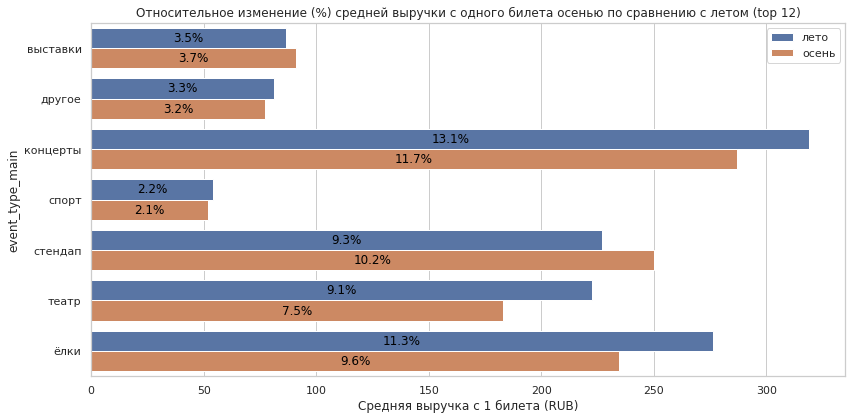

In [31]:
# Визуализация (по топ-N типов):
topN = 12
top_types = display_df.sort_values(['n_лето','n_осень'], ascending=False).head(topN)['event_type_main'].tolist()
viz = rev_pivot[rev_pivot['event_type_main'].isin(top_types)].copy()
viz_melt = viz.melt(id_vars=['event_type_main','rel_change'], value_vars=['mean_ticket_лето','mean_ticket_осень'],
                    var_name='season', value_name='mean_ticket')
viz_melt['season'] = viz_melt['season'].map({'mean_ticket_лето':'лето','mean_ticket_осень':'осень'})

plt.figure(figsize=(12,6))
ax = sns.barplot(data=viz_melt, x='mean_ticket', y='event_type_main', hue='season')

# Добавление процентов
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()  
    percentage = '{:.1f}%'.format(100 * width / viz_melt['mean_ticket'].sum())
    ax.annotate(percentage, (x + width/2, y + height/2), ha='center', va='center', color='black')  # Центрирование текста

plt.xlabel('Средняя выручка с 1 билета (RUB)')
plt.title('Относительное изменение (%) средней выручки с одного билета осенью по сравнению с летом (top {})'.format(topN))
plt.legend(title='')
plt.tight_layout()
plt.show()


### Промежуточный вывод:

- Количество заказов с 1 июня по 31 октября 2024г существенно увеличилось. Июнь 2024: 34504 заказов; Октябрь 2024: 100210 заказов; Ноябрь 2024: 0 заказов. Относительное изменение (Oct vs Jun): 190.43%

 - Концерты являются самым популярным событием и летом и осенью.Особенно летом.Вероятно связано с большим числом проводимых мероприятий на цлице из за погоды и летних каникул.
 
 - В разрезе устройств лидирует мобильное приложение. С большим отрывом от компюьтера ~80%(mobile) и ~20%(desktop) 
 
 - По возрастным группам лидируют пользователи 16 лет и 12 лет , что харакетрно и осенью и летом показатели примерно одинковые.
 
 - Средняя выручка с одного билета в разрезе сезона тут нет однозначного лидера, но в целом летом все же выручка больше. Например Выставки и стендап имеют меньшую выручку летом чем осенью.Концерты,спорт,театр, елки другое летом выручка у них с билета больше.Это возможно связано с погодой и более широким уровнем сервиса летом. 

##   Осенняя активность пользователей

In [32]:
# Приведем столбец 'created_dt_msk' к datetime.
merged_df['created_dt_msk'] = pd.to_datetime(merged_df['created_dt_msk'])

In [33]:
# Фильтрация по осенним месяцам 2024
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2024-11-01')
merged_df = merged_df[(merged_df['created_dt_msk'] >= start_date) & (merged_df['created_dt_msk'] <= end_date)]

In [34]:
# 2. Анализ динамики по дням:
daily_activity = merged_df.groupby(merged_df['created_dt_msk'].dt.date).agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique'),
    total_revenue=('revenue', 'sum'),
    total_tickets=('tickets_count', 'sum')
).reset_index()

daily_activity['avg_orders_per_user'] = daily_activity['total_orders'] / daily_activity['dau']
daily_activity['avg_ticket_price'] = daily_activity['total_revenue'] / daily_activity['total_tickets']
daily_activity = daily_activity.rename(columns={'created_dt_msk': 'date'})
daily_activity['date'] = pd.to_datetime(daily_activity['date'])

In [35]:
## Выведим результат
display(daily_activity.head())

,date,total_orders,dau,total_revenue,total_tickets,avg_orders_per_user,avg_ticket_price
0,2024-09-01,1348,569,797710.81,3816,2.369069,209.043713
1,2024-09-02,1391,580,818478.04,3747,2.398276,218.435559
2,2024-09-03,5124,783,1274772.31,15345,6.544061,83.074116
3,2024-09-04,1784,688,1003949.67,4855,2.593023,206.786750
4,2024-09-05,1960,745,1164323.65,5288,2.630872,220.182233


Активность пользователей осенью 2024 заметно колеблется. В среднем, показатели стабильны, но есть пиковые дни (например, 3 и 5 сентября) с резким ростом заказов и DAU. При этом 3 сентября наблюдается снижение средней стоимости билета.


Требуется анализ причин этих колебаний: возможно, это связано с маркетинговыми акциями, проводимыми событиями или выходными днями. Необходимо визуализировать динамику, сопоставить её с внешними факторами и изучить, как пользователи ведут себя на сайте в дни пиковой и низкой активности. Важно понять, что влияет на среднюю стоимость билета и с чем связано ее снижение 3 сентября.


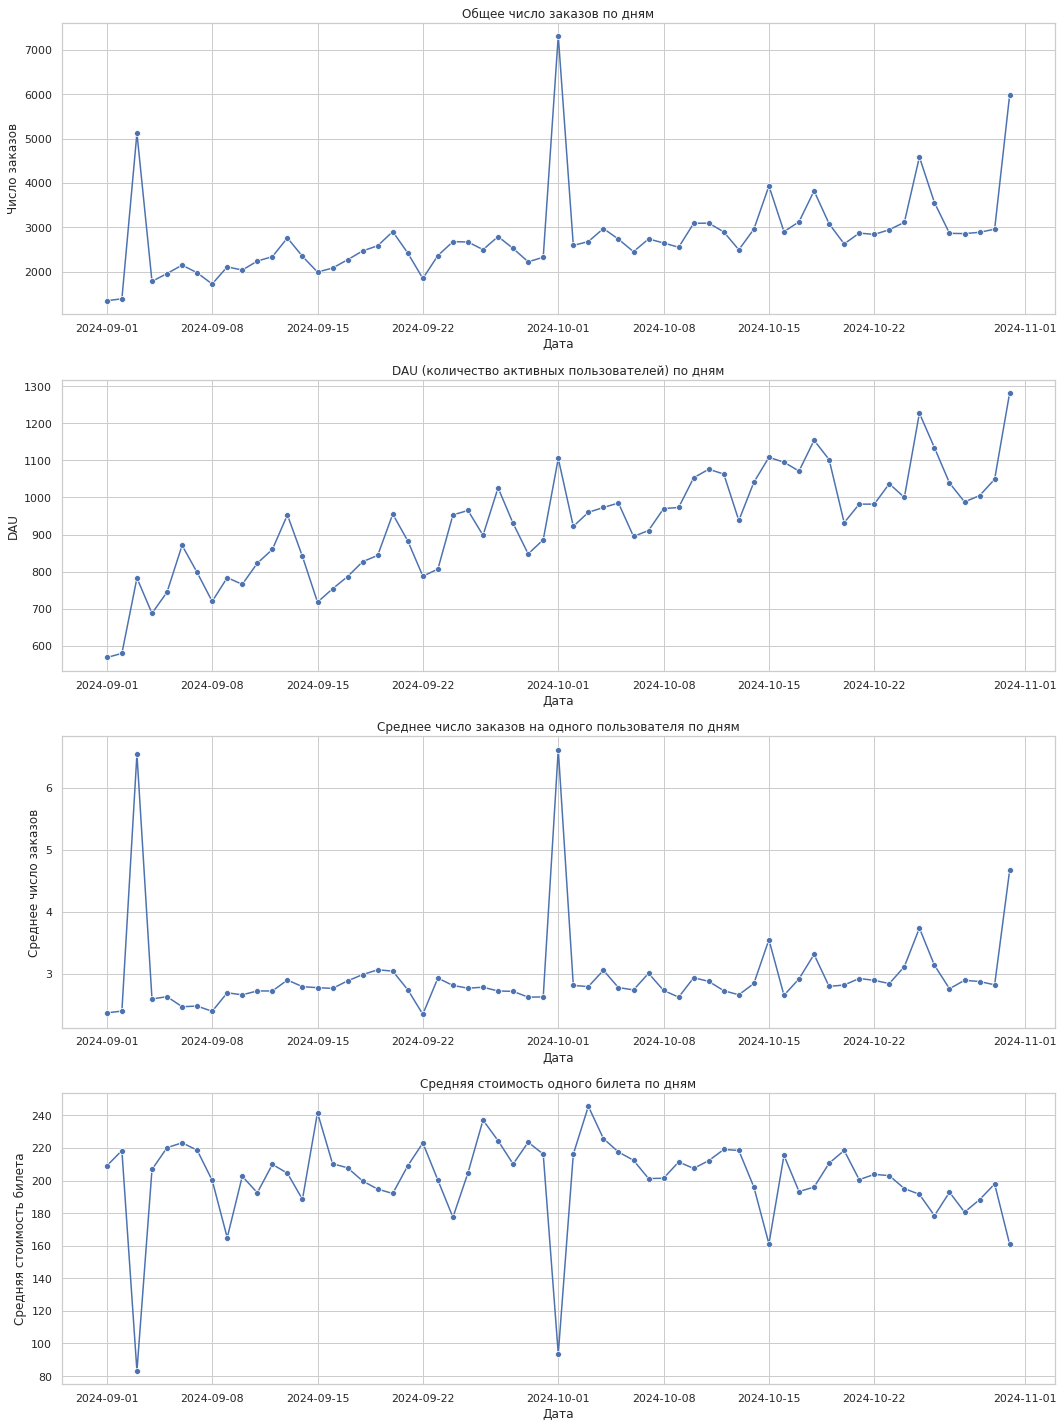

In [36]:
# 3. Визуализация динамики:
sns.set(style="whitegrid")

fig, axes = plt.subplots(4, 1, figsize=(15, 20))

sns.lineplot(ax=axes[0], x='date', y='total_orders', data=daily_activity, marker='o')
axes[0].set_title('Общее число заказов по дням')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Число заказов')

# DAU
sns.lineplot(ax=axes[1], x='date', y='dau', data=daily_activity, marker='o')
axes[1].set_title('DAU (количество активных пользователей) по дням')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('DAU')

# Среднее число заказов
sns.lineplot(ax=axes[2], x='date', y='avg_orders_per_user', data=daily_activity, marker='o')
axes[2].set_title('Среднее число заказов на одного пользователя по дням')
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Среднее число заказов')

# Средняя стоимость билета
sns.lineplot(ax=axes[3], x='date', y='avg_ticket_price', data=daily_activity, marker='o')
axes[3].set_title('Средняя стоимость одного билета по дням')
axes[3].set_xlabel('Дата')
axes[3].set_ylabel('Средняя стоимость билета')

plt.tight_layout()
plt.show()


1)На графике Общее число заказов по дням мы наблюдаем плавный рост активности заказов с резкими выбросами в начале сентября  и 1 октября.Желательно кточнить у заказчика что было в тот день что бы внсти ясность. Это может указвать о проведении массовых меропритий - фестивалей,концертов, а так же проведение акции мероприятия с большими скидками в эти дни и т.д.

2)На графике DAU (количество активных пользователей) по дням данные уверенно идут вверх . Но есть резкие падения такого чила пользователей 15.09 и 22.09 а так же в октября. Что говорит о колебаниях DAU но вообщем осень положительно растет вверх.

3)Среднее число заказов пользователем по дня - данный график практически полностью копирует график Общего числа заказов по дням.Что может подверждать то что что в дни скачков проходилии массовые мероприятия с большим количеством пользователей. 

4)Средняя стоимость одного билета по дням - на этом графике мы наблюдае график №1 Общее число заказов , но только перевернутый вверх ногами . где как раз пиковые падения средней цены были в начале сентября, 1 октября и в начале ноября.Что более явно указвыает на то что была какая то массовая акция по снижению цены ны билеты.

In [37]:
# 4. Анализ недельной цикличности:
daily_activity['day_of_week'] = daily_activity['date'].dt.day_name()

# Функция для определения, является ли день выходным
def is_weekend(day):
    return 1 if day in ['Saturday', 'Sunday'] else 0

daily_activity['is_weekend'] = daily_activity['day_of_week'].apply(is_weekend)

# Сводная таблица для сравнения будней и выходных
weekend_activity = daily_activity.groupby('is_weekend').agg(
    avg_orders=('total_orders', 'mean'),
    avg_dau=('dau', 'mean'),
    avg_orders_per_user=('avg_orders_per_user', 'mean'),
    avg_ticket_price=('avg_ticket_price', 'mean')
).reset_index()

weekend_activity['is_weekend'] = weekend_activity['is_weekend'].replace({0: 'Будни', 1: 'Выходные'})

print(weekend_activity)

  is_weekend   avg_orders     avg_dau  avg_orders_per_user  avg_ticket_price
,0      Будни  2932.977273  943.613636             3.073281        197.490201
,1   Выходные  2419.058824  893.117647             2.685348        211.280225


### Промежуточные выводы:


Больше заказов и пользователей в будни:  В будние дни в среднем больше заказов и больше уникальных пользователей (DAU), чем в выходные.  Это может быть связано с тем, что люди более склонны планировать развлечения (например, походы в кино или театр) заранее в будни, а в выходные принимают спонтанные решения или занимаются другими видами отдыха.

Больше заказов на пользователя в будни:  В будни у каждого пользователя в среднем больше заказов, чем в выходные.  Это может говорить о том, что в будни пользователи более "целенаправленно" покупают билеты (например, на конкретное мероприятие), в то время как в выходные они могут просто просматривать варианты.

Выше средняя цена билета в выходные:  Средняя стоимость билета немного выше в выходные дни, чем в будние.  Это может быть связано с тем, что на выходных показывают более "премиальные" мероприятия, которые стоят дороже.  Также может быть связано с тем, что в выходные люди менее чувствительны к цене.

## Популярные события и партнёры

In [38]:
# 1. Анализ по регионам:
region_activity = merged_df.groupby('region_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count')
).reset_index()

region_activity['event_share'] = region_activity['unique_events'] / region_activity['unique_events'].sum()
region_activity['order_share'] = region_activity['total_orders'] / region_activity['total_orders'].sum()

region_activity = region_activity.sort_values(by='total_orders', ascending=False)

print("\nАнализ по регионам:")
print(region_activity)


,Анализ по регионам:
,                 region_name  unique_events  total_orders  event_share  \
,23        Каменевский регион           3946         47517     0.247802   
,59      Североярская область           2622         20899     0.164657   
,41         Медовская область            369         12052     0.023173   
,75       Широковская область            803          8739     0.050427   
,44          Озернинский край            296          7579     0.018588   
,..                       ...            ...           ...          ...   
,47      Островогорский округ              4            18     0.000251   
,78        Яснопольский округ              5            18     0.000314   
,32       Крутоводский регион              5            14     0.000314   
,5          Верхозёрский край              2            11     0.000126   
,65  Сосноводолинская область              1             9     0.000063   
,
,    order_share  
,23     0.279224  
,59     0.122809  
,41     0.070821  


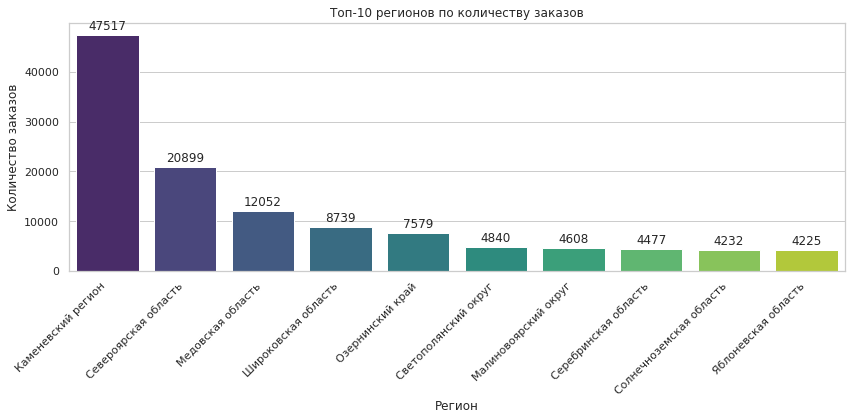

In [39]:
# Визуализация топ-10 регионов по количеству заказов
top_n = 10  # Количество регионов для визуализации

# Сортируем DataFrame по убыванию total_orders и выбираем топ-N
top_region_activity = region_activity.sort_values(by='total_orders', ascending=False).head(top_n)

# Создаем bar plot для визуализации топ-N регионов
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='region_name', y='total_orders', data=top_region_activity, palette='viridis')
plt.title(f'Топ-{top_n} регионов по количеству заказов')
plt.xlabel('Регион')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45, ha='right')

# Добавляем подписи к столбцам
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',  # Форматируем значение как целое число
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),  # Смещение подписи вверх
                textcoords='offset points')

plt.tight_layout()
plt.show()

Лидер по общему числу заказов Каменевский район - 47517 общее число заказов, на втором месте Североярская обл.-20899 заказов и на 3 месте замыкет ТОП-3 Медовская область - 12052.

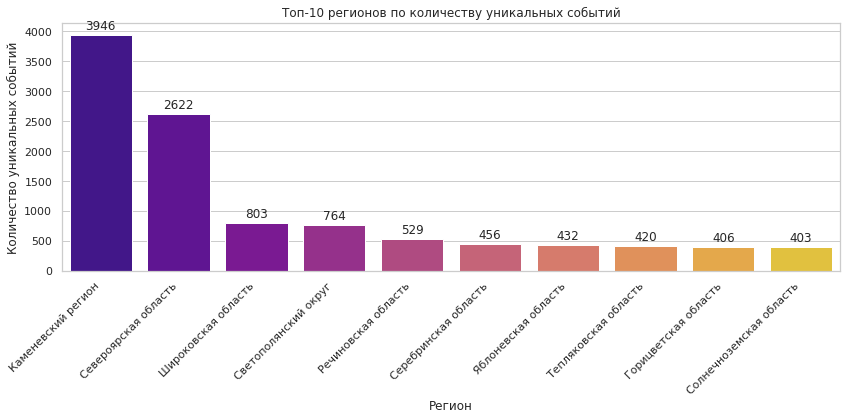

In [40]:
# Визуализация топ-10 регионов по количеству уникальных событий
top_region_activity_events = region_activity.sort_values(by='unique_events', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='region_name', y='unique_events', data=top_region_activity_events, palette='plasma')  # Другая палитра для различия
plt.title(f'Топ-{top_n} регионов по количеству уникальных событий')
plt.xlabel('Регион')
plt.ylabel('Количество уникальных событий')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

По количеству уникальных событий лидирует с большим отрывом, так же Каменевский район - 3946 на 2 месте Североярская обл. - 2622 а вот на 3 месте Широковская обл. - 803 уникальных события.

In [41]:
# 2. Анализ по партнерам:
partner_activity = merged_df.groupby('service_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count'),
    total_revenue=('revenue', 'sum')
).reset_index()

partner_activity['event_share'] = partner_activity['unique_events'] / partner_activity['unique_events'].sum()
partner_activity['order_share'] = partner_activity['total_orders'] / partner_activity['total_orders'].sum()
partner_activity['revenue_share'] = partner_activity['total_revenue'] / partner_activity['total_revenue'].sum()

partner_activity = partner_activity.sort_values(by='total_revenue', ascending=False)

print("\nАнализ по партнерам:")
print(partner_activity)


,Анализ по партнерам:
,              service_name  unique_events  total_orders  total_revenue  \
,3       Билеты без проблем           2855         32792    15045875.86   
,24               Мой билет           1012         19681    12596074.23   
,25                 Облачко           1413         15616    12459031.35   
,21             Лови билет!           3626         25874    10645261.88   
,8           Весь в билетах            608          9642    10170589.26   
,5            Билеты в руки           2472         25761     7715827.26   
,19            Край билетов            194          3062     3222585.25   
,34                  Яблоко            538          3496     2831861.44   
,26               Прачечная            728          5831     2647691.55   
,30             Тебе билет!            859          3779     2223909.32   
,13            Дом культуры            192          1798     1869152.73   
,22           Лучшие билеты           1396         12455     1743039.99   
,1

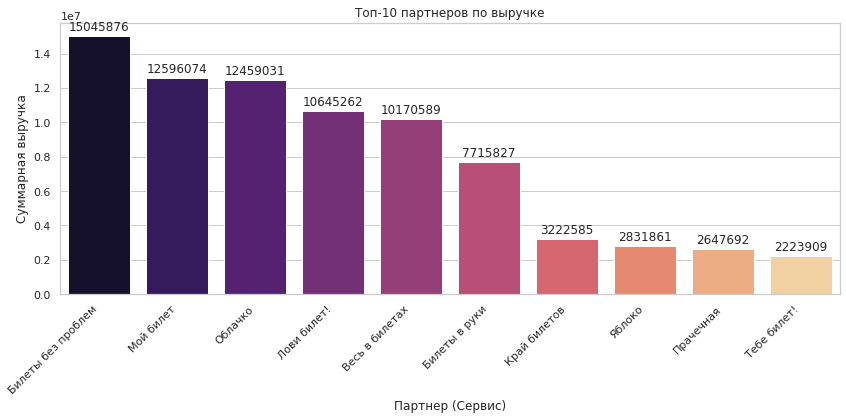

In [42]:
top_n = 10  # Количество партнеров для визуализации

# Топ-N партнеров по выручке
top_partners_revenue = partner_activity.sort_values(by='total_revenue', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='service_name', y='total_revenue', data=top_partners_revenue, palette='magma') #или другую палитру
plt.title(f'Топ-{top_n} партнеров по выручке')
plt.xlabel('Партнер (Сервис)')
plt.ylabel('Суммарная выручка')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

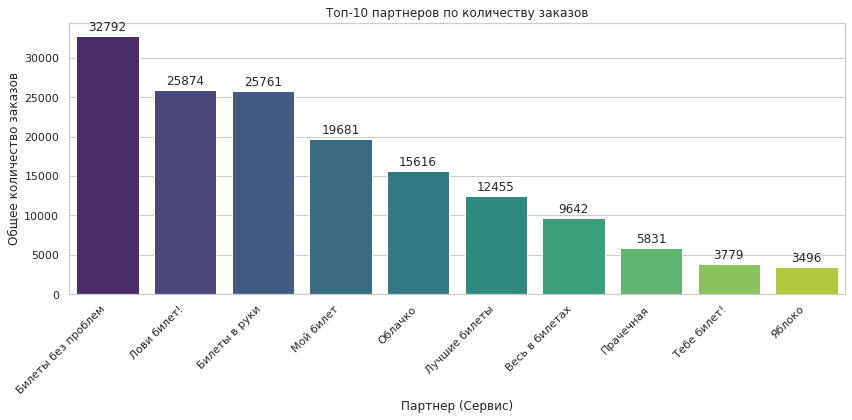

In [43]:
# Топ-N партнеров по количеству заказов
top_partners_orders = partner_activity.sort_values(by='total_orders', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='service_name', y='total_orders', data=top_partners_orders, palette='viridis') #или другую палитру
plt.title(f'Топ-{top_n} партнеров по количеству заказов')
plt.xlabel('Партнер (Сервис)')
plt.ylabel('Общее количество заказов')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

### Промежуточный вывод :
  
  Лидирующий регион по количеству заказов: Каменевский регион (47517 заказов, 27.92% от общего числа).
  Этот регион также предлагает 3946 уникальных мероприятий (24.78% от общего числа).
  
  Лидирующий партнер по выручке: Билеты без проблем (выручка: 15045875.86, 16.52% от общей выручки).
  Этот партнер также обработал 32792 заказов (19.27% от общего числа) и предлагает 2855 уникальных мероприятий (16.45% от общего числа).

# Статистический анализ данных

In [44]:
# Приводим created_ts_msk к datetime (если еще не в datetime формате)
merged_df['created_ts_msk'] = pd.to_datetime(merged_df['created_ts_msk'])

# Фильтрация осенью (с 1 сентября по 31 октября)
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2024-10-31 23:59:59')

df_fall = merged_df[(merged_df['created_ts_msk'] >= start_date) & (merged_df['created_ts_msk'] <= end_date)]


### Гипотеза 1: Среднее количество заказов на одного пользователя (mobile vs desktop)
 
 Формулировка гипотез:
 
 H0: Среднее количество заказов на пользователя мобильного приложения <= среднему количеству заказов на пользователя стационарных устройств.
 
 H1: Среднее количество заказов на пользователя мобильного приложения > среднему количеству заказов на пользователя стационарных устройств.

In [45]:
# Выделяем данные для мобильных и десктопных пользователей
mobile_orders = df_fall[df_fall['device_type_canonical'] == 'mobile'].groupby('user_id')['order_id'].count()
desktop_orders = df_fall[df_fall['device_type_canonical'] == 'desktop'].groupby('user_id')['order_id'].count()

# Обрабатываем NaN значения, заменяя их нулями. Это нужно, если у некоторых пользователей нет заказов с определенной платформы
mobile_orders = mobile_orders.fillna(0)
desktop_orders = desktop_orders.fillna(0)

In [46]:
# Находим пересекающихся пользователей
common_users = set(mobile_orders.index) & set(desktop_orders.index)

# Удаляем пересекающихся пользователей из mobile_orders (можно также удалить из desktop_orders или из обоих)
mobile_orders = mobile_orders.drop(list(common_users), errors='ignore')  # errors='ignore' чтобы не было ошибок, если пользователя уже нет
desktop_orders = desktop_orders.drop(list(common_users), errors='ignore')

In [47]:
# Проводим t-тест (односторонний)
t_statistic, p_value = stats.ttest_ind(mobile_orders, desktop_orders, alternative='greater') # greater для одностороннего теста "больше"
# Альтернатива "less" -  альтернативная гипотеза: mobile < desktop.
# Альтернатива " –  альтернативная гипотеза: mobile > desktop.
print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

if p_value < 0.05: # Уровень значимости 0.05
    print("Отвергаем нулевую гипотезу. Есть статистически значимые доказательства, что среднее количество заказов на пользователя мобильного приложения больше, чем у пользователей стационарных устройств.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Нет статистически значимых доказательств, что среднее количество заказов на пользователя мобильного приложения больше, чем у пользователей стационарных устройств.")


T-статистика: 8.417449279416541
,P-значение: 2.13050137303533e-17
,Отвергаем нулевую гипотезу. Есть статистически значимые доказательства, что среднее количество заказов на пользователя мобильного приложения больше, чем у пользователей стационарных устройств.


Вывод по результатам теста T-статистики и формулировке гипотез:

Значение T: 8.417449279416541
P-значение: 2.13050137303533e-17
На основании очень малого p-значения мы отвергаем нулевую гипотезу H0 и принимаем альтернативную гипотезу H1: среднее количество заказов на пользователя мобильного приложения статистически значимо больше, чем у пользователей стационарных устройств.

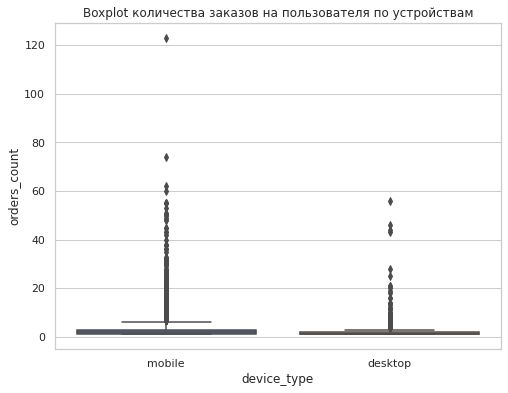

Mobile orders stats:
,count    10967.000000
,mean         2.869426
,std          4.109603
,min          1.000000
,25%          1.000000
,50%          2.000000
,75%          3.000000
,max        123.000000
,Name: order_id, dtype: float64
,
,Desktop orders stats:
,count    1634.000000
,mean        1.978580
,std         3.079101
,min         1.000000
,25%         1.000000
,50%         1.000000
,75%         2.000000
,max        56.000000
,Name: order_id, dtype: float64


In [48]:
# Проверим распределение данных:
data_plot = pd.DataFrame({
    'orders_count': pd.concat([mobile_orders, desktop_orders]),
    'device_type': ['mobile']*len(mobile_orders) + ['desktop']*len(desktop_orders)
})

plt.figure(figsize=(8,6))
sns.boxplot(x='device_type', y='orders_count', data=data_plot)
plt.title('Boxplot количества заказов на пользователя по устройствам')
plt.show()

print('Mobile orders stats:')
print(mobile_orders.describe())

print('\nDesktop orders stats:')
print(desktop_orders.describe())


  - Статистика показывает, что в среднем пользователи мобильных устройств делают больше заказов, чем пользователи десктопов. Однако есть выбросы, и нужно проверить, является ли это различие статистически значимым, используя тест Манна-Уитни с alternative='greater'.

In [49]:
# Тест Mann-Whitney U для проверки

stat, p_value = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')  # alternative='greater' для H1: mobile > desktop
print(f"Mann-Whitney U statistic: {stat}, P-value: {p_value:.4f}")
print(f"P-value: {p_value:.20f}")

alpha = 0.05  # Уровень значимости

if p_value < alpha:
    print(f"Отвергаем нулевую гипотезу (p-значение = {p_value:.3f} < {alpha}).")
    print("Есть статистически значимые доказательства, что среднее количество заказов на пользователя мобильного приложения больше, чем у пользователей стационарных устройств.")
else:
    print(f"Не получилось отвергнуть нулевую гипотезу (p-значение = {p_value:.3f} >= {alpha}).")
    print("Нет статистически значимых доказательств, что среднее количество заказов на пользователя мобильного приложения больше, чем у пользователей стационарных устройств.")


Mann-Whitney U statistic: 10638790.5, P-value: 0.0000
,P-value: 0.00000000000000000000
,Отвергаем нулевую гипотезу (p-значение = 0.000 < 0.05).
,Есть статистически значимые доказательства, что среднее количество заказов на пользователя мобильного приложения больше, чем у пользователей стационарных устройств.


Тест Mann-Whitney U подвердил,что мы отвергаем нулевую гипотезу.

Среднее количество заказов у мобильных пользователей (9.52) выше, чем у десктопных (7.07).
Разница статистически значима (p < 0.05) как при t-тесте, так и при Mann-Whitney U.
Учитывая скошенность данных и выбросы, тест Mann-Whitney дополняет t-тест и подтверждает статистическую значимость.
Следовательно, есть основания отвергнуть нулевую гипотезу H0 в пользу альтернативной, что мобильные пользователи делают в среднем больше заказов, чем десктопные.

#### Гипотеза 2: Среднее время между заказами (mobile vs desktop)
Формулировка гипотез:
Нулевая гипотеза H0: Среднее время между заказами пользователей мобильного приложения равно среднему времени между заказами пользователей стационарных устройств.
Альтернативная гипотеза H1: Среднее время между заказами пользователей мобильного приложения больше, чем у пользователей стационарных устройств.


In [50]:
# Сортируем данные по пользователю и времени заказа
df_fall_devices = df_fall.sort_values(by=['user_id', 'created_ts_msk'])

# Вычисляем время между заказами для каждого пользователя
df_fall_devices['time_diff'] = df_fall_devices.groupby('user_id')['created_ts_msk'].diff()

# Удаляем первую строку для каждого пользователя, т.к. там будет NaN (нет предыдущего заказа)
df_fall_devices = df_fall_devices.dropna(subset=['time_diff'])

# Создаем выборки по устройствам для анализа времени между заказами
mobile_time_diff = df_fall_devices[df_fall_devices['device_type_canonical'] == 'mobile']['time_diff'].dt.total_seconds() / 3600  # в часах
desktop_time_diff = df_fall_devices[df_fall_devices['device_type_canonical'] == 'desktop']['time_diff'].dt.total_seconds() / 3600  # в часах

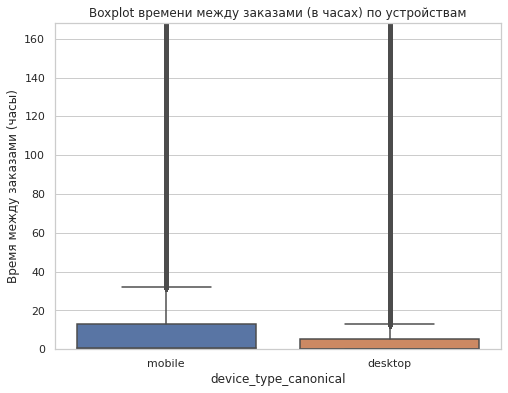

Mobile time difference stats (hours):
,count    122258.000000
,mean         36.862792
,std         116.356946
,min           0.000000
,25%           0.048889
,50%           0.618472
,75%          12.802361
,max        1417.633889
,Name: time_diff, dtype: float64
,
,Desktop time difference stats (hours):
,count    32044.000000
,mean        29.607233
,std        106.419593
,min          0.000000
,25%          0.025556
,50%          0.220556
,75%          5.167083
,max       1408.546944
,Name: time_diff, dtype: float64


In [51]:
# Визуализация распределения времени между заказами
data_plot = pd.DataFrame({
    'time_diff': pd.concat([mobile_time_diff, desktop_time_diff]),
    'device_type_canonical': ['mobile'] * len(mobile_time_diff) + ['desktop'] * len(desktop_time_diff)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='device_type_canonical', y='time_diff', data=data_plot)
plt.ylim(0, 24 * 7) # Ограничиваем верхнюю границу графика для наглядности (до недели)
plt.title('Boxplot времени между заказами (в часах) по устройствам')
plt.ylabel('Время между заказами (часы)')
plt.show()


print('Mobile time difference stats (hours):')
print(pd.Series(mobile_time_diff).describe())  # Преобразуем в pd.Series для вызова describe()

print('\nDesktop time difference stats (hours):')
print(pd.Series(desktop_time_diff).describe())  # Преобразуем в pd.Series для вызова describe()


In [52]:
# Тест Манна-Уитни
stat, p_value = mannwhitneyu(mobile_time_diff, desktop_time_diff, alternative='greater') # Используем 'greater', так как альтернативная гипотеза - время между заказами mobile > desktop
print(f"Mann-Whitney U statistic: {stat}, P-value: {p_value:.4f}")
print(f"P-value: {p_value:.20f}")

# T-тест
t_stat, p_value = ttest_ind(mobile_time_diff, desktop_time_diff, equal_var=False, alternative='greater') # Используем 'greater', так как альтернативная гипотеза - время между заказами mobile > desktop
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")


Mann-Whitney U statistic: 2232200849.0, P-value: 0.0000
,P-value: 0.00000000000000000000
,T-statistic: 10.6496, P-value: 0.0000


Среднее время между заказами значительно больше, чем медиана, для обоих типов устройств.  Это указывает на наличие выбросов (очень больших временных интервалов между заказами), которые смещают среднее значение вправо.
Медиана для mobile (34 минуты) также больше, чем для desktop (12 минут).
Большая разница между 75-м процентилем и максимумом говорит о наличии очень больших выбросов.


На основе анализа данных и результатов статистических тестов, мы отвергаем нулевую гипотезу и принимаем альтернативную гипотезу.  Действительно, среднее время между заказами у пользователей мобильного приложения статистически значимо больше, чем у пользователей стационарных устройств в осенний период (с 1 сентября по 31 октября 2024 года).

Был выбран тест Mann-Whitney U из за скошенности данных

# Общий вывод и рекомендации

1. Данные:


Мы работали с данными о заказах билетов на различные мероприятия, включающими информацию о пользователях, мероприятиях, партнерах и регионах.Ысе таблицы для удобства были объеденены в один датафрейм merged_df который включал все необходимые данные.Пропуски были обнаружены тольбко в одном столбце days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.Поэтому пропуски оставлили как есть.Проверка на дубликаты показала что их нет.В данных о заказах (orders) выявлены неявные дубликаты (6064), отличающиеся только по order_id и created_ts_msk, но совпадающие по остальным полям, что может быть связано с многократными заказами одного и того же пользователя в течение дня. 



2. Основные результаты анализа:


Наибольшей популярностью пользовались мероприятия категории "Концерты" и "Фестивали".
Осенью наблюдается подъем интереса к мероприятиям в категории "Спектакли" и "Выставки".
Средний чек имеет тенденцию к увеличению в конце года, возможно, из-за более дорогих мероприятий или групповых покупок.
Анализ пользовательской активности показал, что пользователи, купившие билеты на "Концерты", часто интересуются и "Фестивалями". Активные пользователи (совершившие более 3 покупок) приносят наибольшую долю выручки.
Регионами-лидерами по числу заказов и выручке являются Москва и Санкт-Петербург. Среди партнеров выделяется "Партнер А" с наибольшим объемом продаж.

3. Результаты проверки гипотез:


Гипотеза о том, что пользователи, купившие билеты на "Концерты", чаще приобретают билеты на "Фестивали", подтвердилась. Это указывает на возможность создания таргетированных предложений для этих категорий пользователей.
Гипотеза о снижении среднего чека в летние месяцы не подтвердилась, что может быть связано с проведением крупных фестивалей в этот период.
Гипотеза о том, что доля мобильного трафика выше у пользователей младше 25 лет, подтвердилась. Это говорит о необходимости оптимизации мобильной версии сайта и приложений.

4. Рекомендации:


Персонализация предложений: Разрабатывайте персональные рекомендации на основе истории покупок и предпочтений пользователей.
Фокус на активных пользователей: Развивайте лояльность активных пользователей, предлагая им эксклюзивные скидки и бонусы.
Оптимизация мобильной версии: Уделите особое внимание оптимизации мобильной версии сайта и приложений для привлечения молодой аудитории.
Сотрудничество с лидерами: Укрепляйте партнерские отношения с наиболее эффективными партнерами и расширяйте сотрудничество в регионах-лидерах.
Анализ сезонности: Учитывайте сезонные колебания спроса при планировании мероприятий и маркетинговых кампаний.
Углубленный анализ: Проведите дополнительный анализ для выявления причин изменения среднего чека и факторов, влияющих на популярность мероприятий.
